# Deep L- layer Neural Network for Image Classification for Cat Vs Non Cat
By Jeeten Patel

In [32]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Initial random parameters for W & b
# layers_dim=(nx,nh1,nh2,nh3...ny)

def initial_parameters(layers_dim):
    np.random.seed(3)
    parameters={}
    L=len(layers_dim)
    
    for i in range(1,L):
        parameters['W'+str(i)]=np.random.randn(layers_dim[i],layers_dim[i-1])*0.01
        parameters['b'+str(i)]=np.zeros((layers_dim[i],1))
        
    return(parameters)

In [34]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)    
    return Z, cache

In [35]:
def activation_function(A_prev,W,b,activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation=='sigmoid':
        A,activation_cache=sigmoid(Z)
    elif activation=='relu':
        A,activation_cache=relu(Z)

    cache=(linear_cache, activation_cache)
    return(A,cache)

In [36]:
def model_forward(X, parameters):
    A=X
    L=len(parameters)//2
    caches=[]
    
    # [Activation -> RELU] (L-1) times
    for i in range(1,L):
        A_prev=A
        A,cache=activation_function(A_prev,parameters['W'+str(i)],parameters['b'+str(i)],'relu')
        caches.append(cache)
        
    # [Activation -> Sigmoid] for Y-hat
    AL,cache=activation_function(A,parameters['W'+str(L)],parameters['b'+str(L)],'sigmoid')
    caches.append(cache)
   
    return(AL,caches)

In [37]:
def cal_cost(AL,Y):
    m=Y.shape[1]
    cost=np.squeeze(-1/m*(np.dot(Y,np.log(AL).T)+np.dot((1-Y),np.log(1-AL).T)))
    return(cost)

### Backward Propagation

In [38]:
def model_backward(dZ, cache):
    A_prev,W,b=cache
    m=A_prev.shape[1]
    
    dW=1/m*np.dot(dZ,A_prev.T)
    db=1/m*np.sum(dZ,axis=1,keepdims=True)
    dA_prev=np.dot(W.T,dZ)
    
    return (dA_prev, dW, db)

In [39]:
def model_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,cache[1])
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, cache[1])
    
    dA_prev, dW, db = model_backward(dZ, linear_cache)
    
    return (dA_prev, dW, db)

In [40]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = model_activation_backward(dAL, current_cache, activation = "sigmoid")

    for i in reversed(range(L-1)):

        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = model_activation_backward(grads["dA" + str(i + 1)], current_cache, activation = "relu")
        grads["dA" + str(i)] = dA_prev_temp
        grads["dW" + str(i + 1)] = dW_temp
        grads["db" + str(i + 1)] = db_temp

    return grads

In [41]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)//2
    for i in range(L):
        parameters["W" + str(i+1)] = parameters["W" + str(i+1)]-learning_rate*grads['dW'+str(i+1)]
        parameters["b" + str(i+1)] = parameters["b" + str(i+1)]-learning_rate*grads['db'+str(i+1)]
    return parameters

## Cat Vs non Cat

In [42]:
train_x, train_y, test_x, test_y, classes = load_data()

y = 1. It's a cat picture.


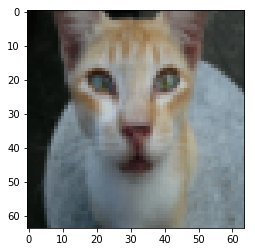

In [43]:
index = 11
plt.imshow(train_x[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [44]:
print('Number of trainning images =',train_x.shape[0])
print('Number of testing images =',test_x.shape[0])
print('Dimension of train_x =',train_x.shape)
print('Dimension of train_y =',test_y.shape)

Number of trainning images = 209
Number of testing images = 50
Dimension of train_x = (209, 64, 64, 3)
Dimension of train_y = (1, 50)


<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

In [45]:
train_x=train_x.reshape(train_x.shape[0],-1).T/255
test_x=test_x.reshape(test_x.shape[0],-1).T/255
print ("train_x's shape: ", train_x.shape)
print ("test_x's shape: " , test_x.shape)

train_x's shape:  (12288, 209)
test_x's shape:  (12288, 50)


## L-layer deep neural network

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">

Functions defined above:

Forward Propagation:
-initial_parameters(layers_dim)
-activation_function(A_prev,W,b,activation)
-model_forward(X, parameters)
-cal_cost(AL,Y)

Backward Propagation:    
 -model_backward(dZ, cache)
 -model_activation_backward(dA, cache, activation)
 -L_model_backward(AL, Y, caches)
 -update_parameters(parameters, grads, learning_rate)

In [46]:
layers_dims = [12288, 20, 7, 5, 1]

In [47]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009

    np.random.seed(1)
    costs = []                        
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = model_forward(X, parameters)

        cost = cal_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


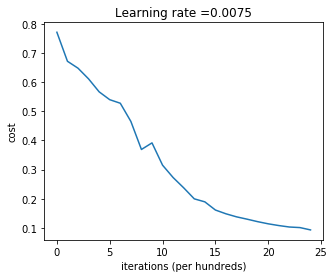

In [48]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [49]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.985645933014


In [50]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


Accuracy: 0.0
y = 1.0, Jeeten's model predicted its a "cat" picture.


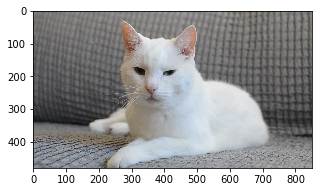

In [57]:
my_image = "1.jpg"
my_label_y = [0] 

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((64*64*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", Jeeten's model predicted its a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")